In [1]:
import numpy as np
import scipy.sparse
import pysindy as ps
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve # для поиска стационарных точек в бифф диагр

# Система Рёсслера
    Аттрактор Рёсслера - хаотический аттрактор, которым обладает система дифференциальных уравнений Рёсслера.
    При значениях параметров a = b = 0.2 && 2.6 <= c <= 4.2 уравнения Рёсслера обладают устойчивым предельным циклом.

In [9]:
def rossler(state, t, a=0.2, b=0.2, c=4.0):
    x, y, z = state
    return -y - z, x + a * y, b + z * (x - c)

## Биффуркационная диаграмма системы (не сделана)

In [153]:
def BiffurcationB(a, c, y0=[0, 0, 0], param0=0, paramN=25, dParam=0.001): # y0 - Начальное значение
    # Задаем диапазон значений параметра
    param = np.arange(param0, paramN, dParam)
    
    fixed_points = [] # Массив для хранения стационарных точек
    # Проходим по всем значениям параметра и вычисляем стационарные точки системы
    for b in param:
        args = (a, b, c)
        y = fsolve(f, y0, args=args)
        fixed_points.append(y)

    
    fixed_points = np.array(fixed_points) # Преобразуем массив стационарных точек в массив numpy

    # Извлекаем координаты стационарных точек
    x_fp = fixed_points[:, 0]
    y_fp = fixed_points[:, 1]
    z_fp = fixed_points[:, 2]

    # Рисуем бифуркационную диаграмму
    plt.plot(param, x_fp, ',', color='blue')
    plt.plot(param, y_fp, ',', color='green')
    plt.plot(param, z_fp, ',', color='red')
    plt.grid()
    plt.xlabel('c')
    plt.ylabel('x, y, z')
    plt.title('Бифуркационная диаграмма для аттрактора Рёсслера')
    plt.show()
    
BiffurcationB(0.2, 4)

## Построение графиков

In [22]:
def plot_time_series(x_train, time_steps, ylabel=['x', 'y', 'z']):
    _, time_series = plt.subplots(nrows=3, ncols=1)

    for i in range(len(time_series)):
        time_series[i].plot(time_steps, x_train[:, i])
        time_series[i].grid()
        time_series[i].set_xlabel('t')
        time_series[i].set_ylabel(ylabel[i])


def plot_time_series_comparison(x_train, x_sim, time_steps, ylabel=['x', 'y', 'z']):
    _, time_series = plt.subplots(nrows=3, ncols=1)

    for i in range(len(time_series)):
        time_series[i].plot(time_steps, x_train[:, i])
        time_series[i].plot(time_steps, x_sim[:, i], '--')
        time_series[i].grid()
        time_series[i].set_xlabel('t')
        time_series[i].set_ylabel(ylabel[i])


def plot_solution(x_train, initial_condition, ylabel=['x', 'y', 'z']):
    _, time_series = plt.subplots(nrows=3, ncols=1)

    for i in range(len(time_series) - 1):
        time_series[i].plot(x_train[:, 0], x_train[:, i + 1], label='Ground truth')
        time_series[i].plot(initial_condition[0], initial_condition[i + 1], "ko", label="Initial condition")
        time_series[i].set_xlabel('x')
        time_series[i].set_ylabel(ylabel[i + 1])
        time_series[i].grid()

    time_series[2].plot(x_train[:, 1], x_train[:, 2], label='Ground truth')
    time_series[2].plot(initial_condition[1], initial_condition[2], "ko", label="Initial condition")
    time_series[2].set_xlabel(ylabel[1])
    time_series[2].set_ylabel(ylabel[2])
    time_series[2].grid()

    time_series[0].legend()
    plt.show()


def plot_solution_comparison(x_train, x_sim, initial_condition, ylabel=['x', 'y', 'z'], method='Nothing'):
    _, time_series = plt.subplots(nrows=3, ncols=1)

    for i in range(len(time_series) - 1):
        time_series[i].plot(x_train[:, 0], x_train[:, i + 1], label='Ground truth')
        time_series[i].plot(x_sim[:, 0], x_sim[:, i + 1], '--', label=method)
        time_series[i].plot(initial_condition[0], initial_condition[i + 1], "ko", label="Initial condition")
        time_series[i].set_xlabel('x')
        time_series[i].set_ylabel(ylabel[i + 1])
        time_series[i].grid()

    time_series[2].plot(x_train[:, 1], x_train[:, 2], label='Ground truth')
    time_series[2].plot(x_sim[:, 1], x_sim[:, 2], '--', label=method)
    time_series[2].plot(initial_condition[1], initial_condition[2], "ko", label="Initial condition")
    time_series[2].set_xlabel(ylabel[1])
    time_series[2].set_ylabel(ylabel[2])
    time_series[2].grid()

    time_series[0].legend()
    plt.show()

def plot_3D_solution(x_train):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Rossler Attractor')
    plt.show()

def plot_3D_solution_comparison(x_train, x_sim, method='Nothing'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2])
    ax.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], '--', label=method)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title('Rossler Attractor')
    plt.legend()
    plt.show()

## Алгоритмы аппроксимации

In [11]:
# x_train - np.array([],[],[]) временной ряд
# time - np.array[0, T] с шагом dt, time[0] = 0, time[1] = time[0] + dt
def ps_sol(x_train, time, optimizer=ps.optimizers.STLSQ(0.1), feature_library=ps.PolynomialLibrary(2),
           feature_names=('x', 'y', 'z'), differentiation_method=ps.differentiation.FiniteDifference(2)):
    model = ps.SINDy(optimizer=optimizer, feature_library=feature_library, feature_names=feature_names, differentiation_method=differentiation_method)
    model.fit(x_train, time)
    model.print()
    return model

(300000, 3)
(x)' = -1.000 y + -1.000 z
(y)' = 1.000 x + 0.300 y
(z)' = 0.300 1 + -2.600 z + 1.000 x z


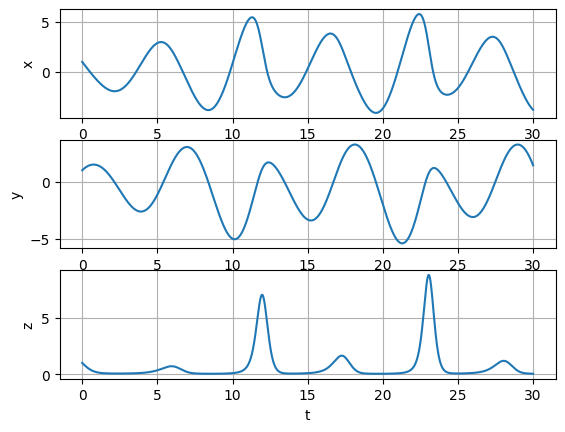

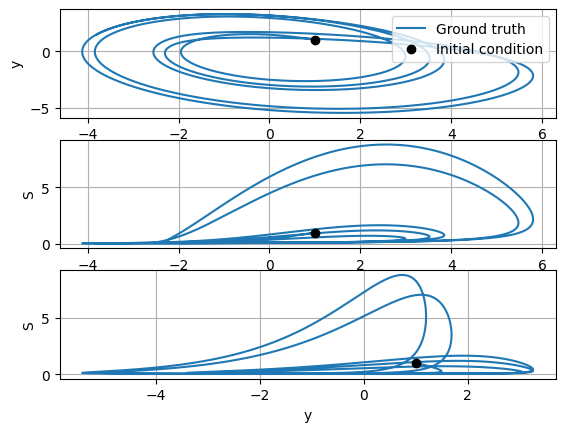

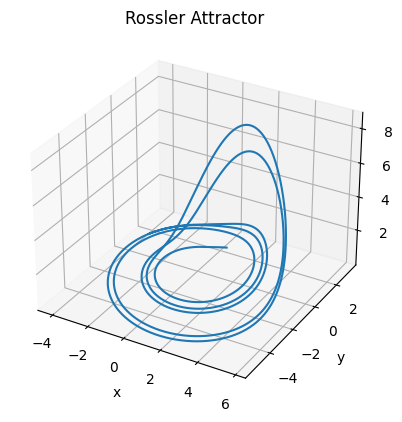

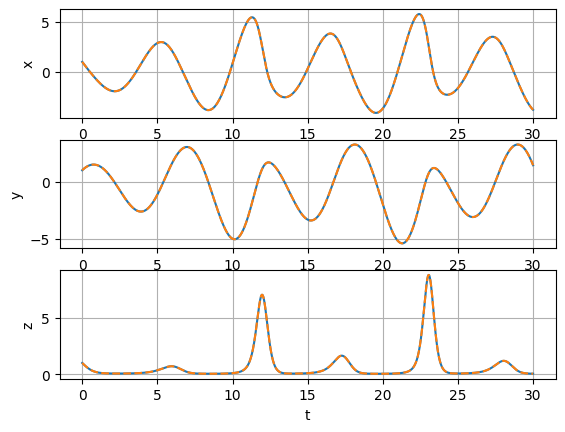

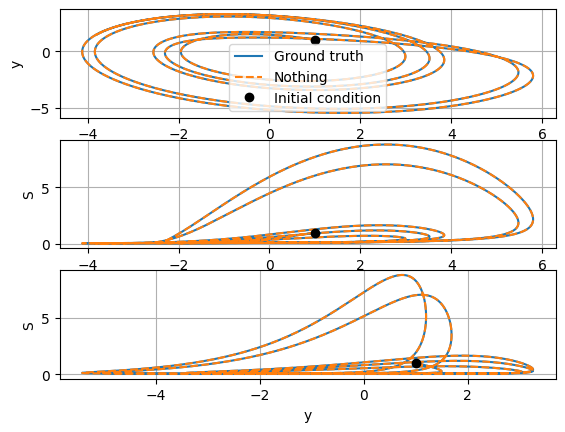

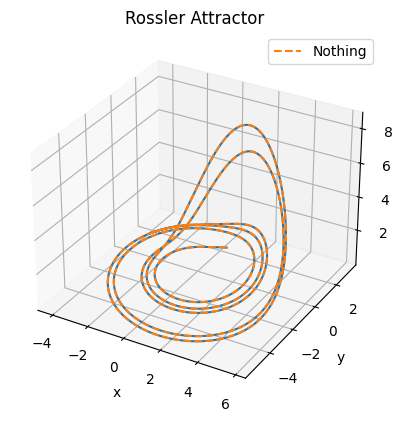

In [24]:
def main():
    a = b = 0.3
    c = 2.6
    state0 = [1, 1, 1]
    dt = 0.0001
    time_steps = np.arange(0, 30, dt)

    x_train = odeint(rossler, state0, time_steps, args=(a, b, c))
    print(x_train.shape)
    model_ps = ps_sol(x_train, time_steps)
    x_sim = model_ps.simulate(state0, time_steps)
    plot_time_series(x_train, time_steps)
    plot_solution(x_train, state0, 'pySINDY')
    plot_3D_solution(x_train)

    plot_time_series_comparison(x_train, x_sim, time_steps)
    plot_solution_comparison(x_train, x_sim, state0, 'pySINDY')
    plot_3D_solution_comparison(x_train, x_sim)

main()

In [48]:
a = b = 0.2
c = 5
state0 = [1, 1, 1]
dt = 0.0001
time_steps = np.arange(0, 50, dt)

x_train = odeint(f, state0, time_steps, args=(a, b, c))
print(len(x_train))

500000


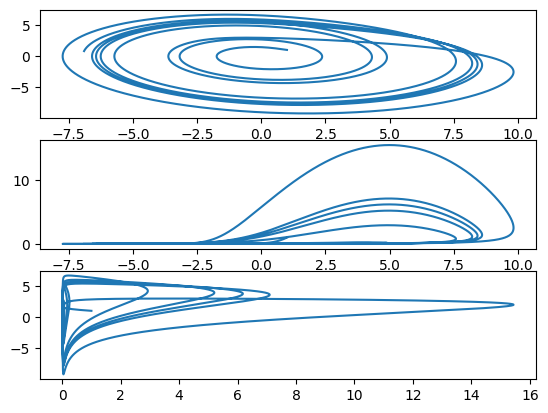

In [49]:
plot_system(x_train)

In [52]:
model_2 = ps.SINDy(optimizer=ps.BaseOptimizer(), feature_library=ps.PolynomialLibrary(3), feature_names=('x', 'y', 'z'), differentiation_method=ps.differentiation.FiniteDifference(2))

TypeError: Can't instantiate abstract class BaseOptimizer with abstract method _reduce

SINDy уже не справляется с данной системой

In [51]:
model_2.fit(x_train)
model_2.print()

(x)' = 0.000
(y)' = 0.000
(z)' = 0.000


C:\Users\cote-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pysindy\optimizers\stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


In [104]:
# Определяем систему уравнений для аттрактора Рёсслера
def rossler(t, y, a=0.2, b=0.2, c=4):
    x, y, z = y
    return np.array([-y - z, x + a*y, b + z*(x - c)])

# Интегрируем систему уравнений для получения временных рядов
t_span = [0, 100]
y0 = [0, 1, 1]
sol = solve_ivp(rossler, t_span, y0, t_eval=np.linspace(0, 50, 10000))

# Создаем объект SINDy и идентифицируем нелинейные динамические уравнения
model = ps.SINDy(differentiation_method=ps.FiniteDifference(),
    feature_library=ps.PolynomialLibrary(degree=2),
    feature_names=['x', 'y', 'z'],
    #optimizer=ps.optimizers.SSR(max_iter=40, alpha=0.01))
    optimizer=ps.optimizers.FROLS())



MemoryError: Unable to allocate 466. GiB for an array with shape (10000, 50015001) and data type bool

In [105]:
model.fit(sol.y.T)
model.print()
x_sim = model.simulate(y0, np.linspace(0, 50, 100000))

(x)' = -0.005 y + -0.005 z
(y)' = 0.005 x + 0.001 y
(z)' = 0.001 1 + -0.020 z + 0.005 x z


In [121]:
x_sim = model.simulate(y0, np.linspace(0, 10000, 100000))
print(x_sim.shape)
print(sol.y.shape)

(100000, 3)
(3, 10000)


In [122]:
print(x_sim[:, 2])

[1.         0.99811768 0.99623859 ... 0.03836146 0.03837354 0.03838562]


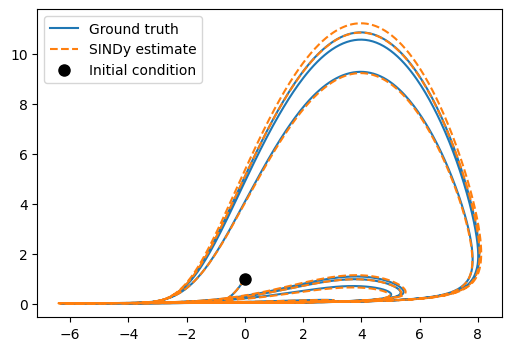

In [123]:
plt.figure(figsize=(6, 4))
plt.plot(sol.y.T[:, 0], sol.y.T[:, 2], label='Ground truth')
plt.plot(x_sim[:, 0], x_sim[:, 2], '--', label='SINDy estimate')
plt.plot(sol.y.T[0, 0], sol.y.T[0, 2], "ko", label="Initial condition", markersize=8)
plt.legend()
plt.draw()
plt.show()

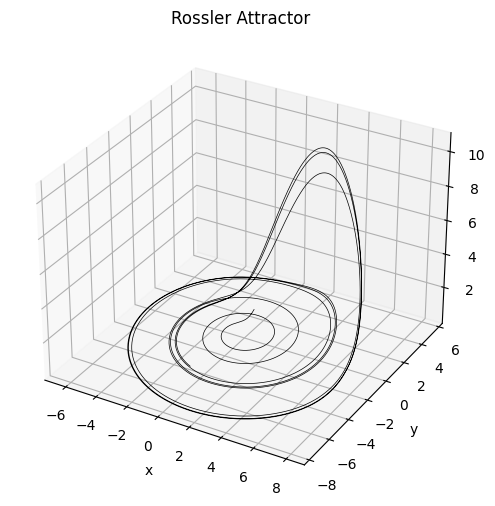

In [118]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(sol.y[0], sol.y[1], sol.y[2], lw=0.5, color='black')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Rossler Attractor')
plt.show()

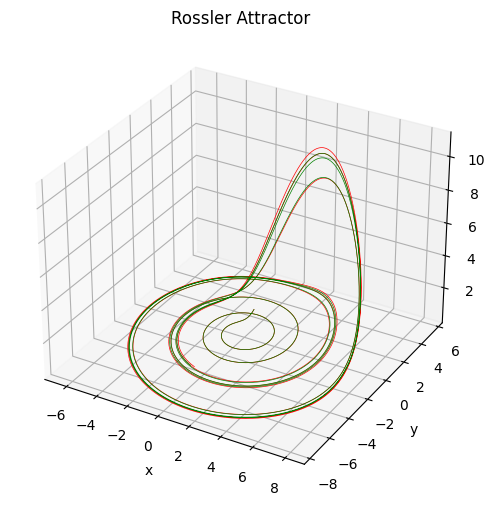

In [127]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_sim.T[0], x_sim.T[1], x_sim.T[2], lw=0.5, color='red')
ax.plot(sol.y[0], sol.y[1], sol.y[2], lw=0.5, color='green')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Rossler Attractor')
plt.show()

In [ ]:
import numpy as np

# Определяем систему уравнений для аттрактора Рёсслера
def rossler(t, y, a=0.2, b=0.2, c=4):
    x, y, z = y
    return np.array([-y - z, x + a*y, b + z*(x - c)])

# Интегрируем систему уравнений для получения временных рядов
t_span = [0, 100]
y0 = [0, 1, 1]
sol = solve_ivp(rossler, t_span, y0, t_eval=np.linspace(0, 50, 10000))

# Определяем параметры резервуарных вычислений
reservoir_size = 1000  # Размер резервуара
spectral_radius = 0.8  # Спектральный радиус матрицы связей
input_scaling = 0.5  # Масштабирование входного сигнала
leaking_rate = 0.3  # Коэффициент утечки

# Инициализируем матрицу связей резервуара
W_res = np.random.rand(reservoir_size, reservoir_size) - 0.5
W_res *= spectral_radius / np.max(np.abs(np.linalg.eigvals(W_res)))

# Инициализируем векторы входных и выходных сигналов резервуара
u_res = np.zeros((reservoir_size, 1))
x_res = np.zeros((reservoir_size, 1))

# Инициализируем матрицу обучения
X = np.zeros((reservoir_size + 1, sol.y.shape[1]))

# Инициализируем резервуар случайными значениями
x_res[:, 0] = np.random.rand(reservoir_size)

# Проходим по всем точкам временного ряда и обновляем состояние резервуара
for i in range(1, sol.y.shape[1]):
    # Обновляем входной сигнал резервуара
    u_res = input_scaling * sol.y[:, i].reshape(-1, 1)

    # Вычисляем новое состояние резервуара
    x_res = (1 - leaking_rate) * x_res + leaking_rate * np.tanh(np.dot(W_res, x_res) + np.dot(u_res, sol.t[i]))

    # Добавляем текущее состояние резервуара в матрицу обучения
    X[:, i] = np.concatenate((x_res.ravel(), [1]))

# Используем метод наименьших квадратов для аппроксимации временного ряда
Y = sol.y.T
W_out = np.dot(np.linalg.inv(np.dot(X, X.T)), np.dot(X, Y))

# Примен